In [418]:
import pickle
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import ast
from typing import List
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import SubsetRandomSampler
import torch
from torch import nn
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [164]:
genres = pd.read_csv('fma_metadata/genres.csv')

Топ 16 корневых жанров которые будем классифицировать

In [165]:
top_genres = genres[genres['parent'] == 0]
top_genres

,genre_id,#tracks,parent,title,top_level
1,2,5271,0,International,2
2,3,1752,0,Blues,3
3,4,4126,0,Jazz,4
4,5,4106,0,Classical,5
7,8,868,0,Old-Time / Historic,8
8,9,1987,0,Country,9
9,10,13845,0,Pop,10
11,12,32923,0,Rock,12
12,13,730,0,Easy Listening,13
13,14,1499,0,Soul-RnB,14


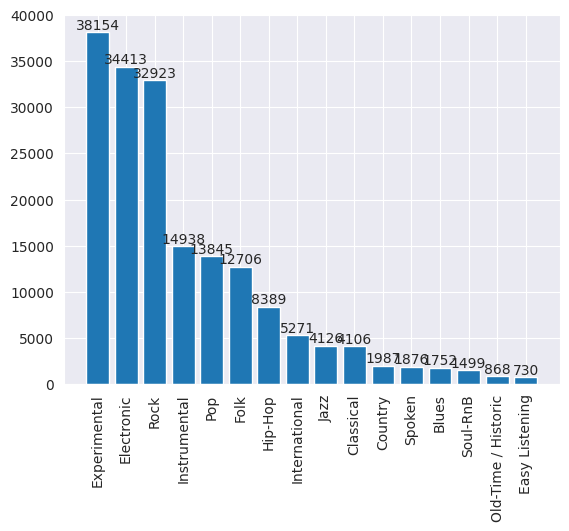

In [166]:
top_genres_sorted = top_genres.sort_values('#tracks', ascending=False)

fig, ax = plt.subplots()
ax.bar(top_genres_sorted.title, top_genres_sorted['#tracks'])

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax.bar_label(ax.containers[0], label_type='edge')
!

In [167]:
def get_top_genre_id(genres: pd.DataFrame, genre_id: int) -> int:
    top_genre_id = genres[genres['genre_id'] == genre_id]['top_level']
    if top_genre_id is None:
        raise Exception(f'Жанр с id {genre_id} не найден')
    return int(top_genre_id)

Видим что жанры очень не балансны, это жанры большого датасета. В нашем будет еще меньше

In [168]:
class FeatureNormalizer:
    @staticmethod
    def normalize(features: List[np.array]) -> List[np.array]:
        initial_len = len(features)
        scaler = StandardScaler()
        features = np.vstack(tuple(features))
        features = scaler.fit_transform(features)
        return np.vsplit(features, initial_len)

In [169]:
id_to_features = pickle.load(open('test.p', 'rb')) # id - feature array

In [170]:
list(id_to_features.keys())[0]

'38967'

In [171]:
id_to_features['38967']

array([[-2.30273560e+02,  1.32053925e+02,  8.75435734e+00, ...,
         1.17187500e-02,  1.28249494e+03,  2.65935059e+03],
       [-3.11146515e+02,  1.04479111e+02,  1.38904810e+01, ...,
         3.07617188e-02,  8.44686281e+02,  1.29199219e+03],
       [-2.53006592e+02,  1.01088303e+02, -1.76724072e+01, ...,
         4.49218750e-02,  1.53926595e+03,  3.47761230e+03],
       ...,
       [-3.48624786e+02,  1.35259094e+02,  1.87926903e+01, ...,
         1.66015625e-02,  4.91190211e+02,  7.85961914e+02],
       [-3.41956787e+02,  1.22363289e+02,  8.61588955e+00, ...,
         1.80664062e-02,  5.28709554e+02,  7.96728516e+02],
       [-2.38076355e+02,  1.25543945e+02,  2.52138863e+01, ...,
         1.02539062e-02,  1.30200118e+03,  2.74548340e+03]])

In [172]:
normalized_features = FeatureNormalizer.normalize(id_to_features.values())

In [173]:
len(id_to_features.keys())

7994

In [174]:
id_to_features = {key: normalized_features[idx] for idx, key in enumerate(id_to_features.keys())}

In [175]:
len(id_to_features.keys())

7994

In [176]:
normalized_features[0]

array([[-0.69363759,  0.35429725,  0.41503256, ..., -1.10408476,
        -0.57450222, -0.53723983],
       [-1.35558006, -0.22555946,  0.56635586, ..., -0.80988851,
        -1.03314189, -1.19717315],
       [-0.87970671, -0.29686303, -0.3635673 , ..., -0.59112719,
        -0.30551401, -0.1423191 ],
       ...,
       [-1.66233848,  0.42169713,  0.71078744, ..., -1.02864982,
        -1.40345735, -1.44140045],
       [-1.60776113,  0.15051781,  0.41095295, ..., -1.00601934,
        -1.36415284, -1.43620412],
       [-0.75750322,  0.21740222,  0.89997225, ..., -1.12671524,
        -0.55406787, -0.49566923]])

In [177]:
id_to_features['38967']

array([[-0.69363759,  0.35429725,  0.41503256, ..., -1.10408476,
        -0.57450222, -0.53723983],
       [-1.35558006, -0.22555946,  0.56635586, ..., -0.80988851,
        -1.03314189, -1.19717315],
       [-0.87970671, -0.29686303, -0.3635673 , ..., -0.59112719,
        -0.30551401, -0.1423191 ],
       ...,
       [-1.66233848,  0.42169713,  0.71078744, ..., -1.02864982,
        -1.40345735, -1.44140045],
       [-1.60776113,  0.15051781,  0.41095295, ..., -1.00601934,
        -1.36415284, -1.43620412],
       [-0.75750322,  0.21740222,  0.89997225, ..., -1.12671524,
        -0.55406787, -0.49566923]])

In [178]:
metadata = pd.read_csv('fma_metadata/raw_tracks.csv')[['track_id', 'track_genres']]
metadata.dropna(inplace=True)
metadata['track_genres'].apply(lambda x: len(ast.literal_eval(x))).value_counts()

3     37868
2     29251
1     27788
4      6005
5      3561
6      1485
7       381
8       355
9       161
10       94
12       81
11       52
13       28
21        3
15        1
20        1
25        1
16        1
14        1
Name: track_genres, dtype: int64

Видим что чаще всего одна песня принадлежит нескольким жанрам. Скорее всего все родители учитываются. Надо проверить. Попробуем пока брать по 0 индексу

In [179]:
metadata['first_genre'] = metadata['track_genres'].apply(lambda x: ast.literal_eval(x)[0]['genre_id'])

In [180]:
metadata['first_genre'].value_counts()

15     20594
1       9183
12      6904
38      6732
10      6225
       ...  
444        2
502        2
173        1
619        1
170        1
Name: first_genre, Length: 149, dtype: int64

In [181]:
metadata['top_genre'] = metadata['first_genre'].apply(lambda genre_id: get_top_genre_id(genres, int(genre_id)))

In [182]:
metadata

,track_id,track_genres,first_genre,top_genre
0,2,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",21,21
1,3,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",21,21
2,5,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",21,21
3,10,"[{'genre_id': '10', 'genre_title': 'Pop', 'gen...",10,10
4,20,"[{'genre_id': '76', 'genre_title': 'Experiment...",76,10
...,...,...,...,...
109722,155316,"[{'genre_id': '25', 'genre_title': 'Punk', 'ge...",25,12
109723,155317,"[{'genre_id': '25', 'genre_title': 'Punk', 'ge...",25,12
109724,155318,"[{'genre_id': '25', 'genre_title': 'Punk', 'ge...",25,12
109725,155319,"[{'genre_id': '25', 'genre_title': 'Punk', 'ge...",25,12


In [183]:
sorted_labels = sorted(list(metadata['top_genre'].unique()))
sorted_labels

[2, 3, 4, 5, 8, 9, 10, 12, 13, 14, 15, 17, 20, 21, 38, 1235]

CrossEntropyLoss принимает метки классов от 0 до C-1, напишем прямое и обратное преобразование меток классов

In [184]:
labels_to_idx = {label: i for i, label in enumerate(sorted_labels)}
idx_to_label = {i: label  for i, label in enumerate(sorted_labels)}

assert idx_to_label[labels_to_idx[2]] == 2

In [185]:
id_to_genre = { str(k): labels_to_idx[v] for k, v in metadata.set_index('track_id').to_dict()['top_genre'].items()}

In [186]:
class FeatureLabelMerger:
    @staticmethod
    def merge(id_to_feature: dict[str, any], id_to_label: dict[str, any]):
        merged = []

        for key in id_to_label.keys():
            if key in id_to_feature:
                merged.append((id_to_feature[key], id_to_label[key]))

        return np.array(merged, dtype=object)

In [187]:
merged_feature_label = FeatureLabelMerger.merge(id_to_features, id_to_genre)

In [266]:
class GenreClassificationDataset(Dataset):
    def __init__(self, features_with_labels: List[tuple]):
        self.features_with_labels = features_with_labels

    def __len__(self):
        return len(self.features_with_labels)

    def __getitem__(self, idx):
        features, label = self.features_with_labels[idx]

        return features.astype('float32'), label


Создаем кастомный датасет

In [267]:
dataset = GenreClassificationDataset(merged_feature_label)

Стратифицированно разбиваем датасет на train val и test

In [268]:
TRAIN_SIZE = 0.8
VAL_SIZE = 0.1
TEST_SIZE = 1 - TRAIN_SIZE - VAL_SIZE

assert TRAIN_SIZE + VAL_SIZE + TEST_SIZE == 1

In [269]:
train_idx, val_idx = train_test_split(np.arange(len(merged_feature_label)), train_size = TRAIN_SIZE, shuffle=True, stratify=merged_feature_label[:, 1], random_state=42)

val_idx, test_idx = train_test_split(val_idx, train_size= VAL_SIZE / (1 - TRAIN_SIZE), shuffle=True, stratify=merged_feature_label[val_idx][:, 1], random_state=42)

In [270]:
display(train_idx.shape)
display(val_idx.shape)
display(test_idx.shape)

(6395,)

(799,)

(800,)

In [432]:
BATCH_SIZE = 64
NUM_CLASSES = 16
DEVICE = torch.device('cuda')

In [433]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, drop_last=True, sampler=train_sampler)
val_data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, drop_last=True, sampler=val_sampler)
test_data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, drop_last=True, sampler=test_sampler)

In [509]:
def calculate_accuracy(y_pred, y_true):
    correct_pred = y_pred == y_true
    acc = correct_pred.sum() / len(correct_pred)

    acc = torch.round(acc * 100)

    return acc.item()

def evaluate(model, dataloader, criterion, return_pred: bool):
    loss_sum = 0
    accuracy_sum = 0

    pred_global = []
    true_global = []

    model.eval()
    with torch.no_grad():
        for x_data, y_true in dataloader:
            x_data, y_true = x_data.to(DEVICE), y_true.to(DEVICE)
            pred_logits = model(x_data)
            batch_loss = criterion(pred_logits, y_true).item()
            loss_sum += batch_loss

            y_pred_softmax = torch.log_softmax(pred_logits, dim = 1)
            _, y_pred = torch.max(y_pred_softmax, dim = 1)

            accuracy_sum += calculate_accuracy(y_pred, y_true)

            if return_pred:
                pred_global.append(y_pred)
                true_global.append(y_true)

    return loss_sum / len(dataloader), accuracy_sum / len(dataloader), (torch.cat(pred_global), torch.cat(true_global)) if return_pred else (torch.tensor([]).to(DEVICE), torch.tensor([]).to(DEVICE))


def executor(model, train_dataloader, val_dataloader, epochs, learning_rate=1e-3, evaluate_per_iteration = 300, weight_decay = 0.05, early_stop_class = None) -> (np.array, np.array):
    # Определяем лосс функцию - кроссэнтропия
    criterion = nn.CrossEntropyLoss() # Можно забацать веса

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # Попробовать weight decay

    train_progress = [] # [(epoch_loss, epoch_accuracy)]
    val_progress = [] # [(epoch_loss, epoch_accuracy)]

    for epoch in tqdm(range(epochs)):
        # print(f"epoch: {epoch}")

        train_epoch_loss = 0
        val_epoch_loss = 0

        train_iter_num = 0
        val_iter_num = 0


        train_epoch_accuracy = 0
        val_epoch_accuracy = 0

        # for x_data, y_true in tqdm(train_dataloader):
        for x_data, y_true in train_dataloader:
            train_iter_num += 1

            x_data, y_true = x_data.to(DEVICE), y_true.to(DEVICE)
            model.train()
            pred_logits = model(x_data)
            optimizer.zero_grad()
            loss = criterion(pred_logits, y_true)
            loss.backward()
            optimizer.step()

            y_pred_softmax = torch.log_softmax(pred_logits, dim = 1)
            _, y_pred = torch.max(y_pred_softmax, dim = 1)

            train_epoch_loss += loss.item()
            train_epoch_accuracy += calculate_accuracy(y_pred, y_true)

            if train_iter_num % evaluate_per_iteration == evaluate_per_iteration - 1:
                val_iter_num += 1
                val_loss, val_acc, _ = evaluate(model, val_dataloader, criterion, return_pred=False)
                val_epoch_loss += val_loss
                val_epoch_accuracy += val_acc

        # if early_stop_class is not None:
        #     early_stop_class(np.mean([x[0] for x in loss_epoch_progress]))
        #     print('best_loss', early_stop_class.best_loss)
        #     if early_stop_class.early_stop:
        #         return [item for sublist in loss_global_progress for item in sublist]

        train_progress.append((train_epoch_loss / max(train_iter_num, 1), train_epoch_accuracy / max(train_iter_num, 1)))
        val_progress.append((val_epoch_loss / max(val_iter_num, 1), val_epoch_accuracy / max(val_iter_num, 1)))

    return np.array(train_progress), np.array(val_progress)

In [510]:
class FeedForwardSimpleModel(nn.Module):
    def __init__(self, input_dim, num_class):
        super(FeedForwardSimpleModel, self).__init__()

        self.layer_0 = nn.Linear(input_dim, 2048)
        self.layer_1 = nn.Linear(2048, 1024)
        self.layer_2 = nn.Linear(1024, 512)
        self.layer_3 = nn.Linear(512, 128)
        self.layer_4 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class)

        self.relu = nn.ReLU()
        self.batchnorm0 = nn.BatchNorm1d(2048)
        self.batchnorm1 = nn.BatchNorm1d(1024)
        self.batchnorm2 = nn.BatchNorm1d(512)
        self.batchnorm3 = nn.BatchNorm1d(128)
        self.batchnorm4 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = x.flatten(start_dim = 1)

        x = self.layer_0(x)
        x = self.batchnorm0(x)
        x = self.relu(x)

        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)

        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)

        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)

        x = self.layer_4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)

        x = self.layer_out(x)

        return x

In [534]:
ff_simple_model = FeedForwardSimpleModel(376 * 15, NUM_CLASSES).to(DEVICE)
train_progress, val_progress = executor(ff_simple_model, train_dataloader = train_data_loader, val_dataloader=val_data_loader, epochs=100, learning_rate=1e-4, weight_decay=0.01, evaluate_per_iteration=33)

100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


In [535]:
def plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy']):
    fig, axes = plt.subplots(len(metrics), 2)
    for i in range(len(metrics)):
        axes[i][0].plot(train_progress[:, i])
        axes[i][0].set_title(f'train_{metrics[i]}')
        axes[i][1].plot(val_progress[:, i])
        axes[i][1].set_title(f'val_{metrics[i]}')

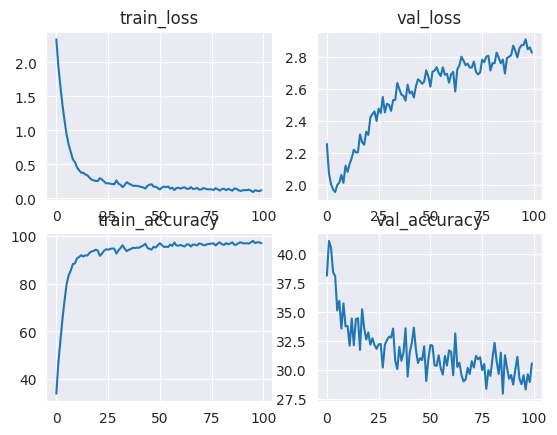

In [536]:
plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

In [537]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(ff_simple_model, test_data_loader, criterion=nn.CrossEntropyLoss(), return_pred=True)

Почему 7 когда большой lr и 15 когда маленький, еще от weight decay зависит

<AxesSubplot: >

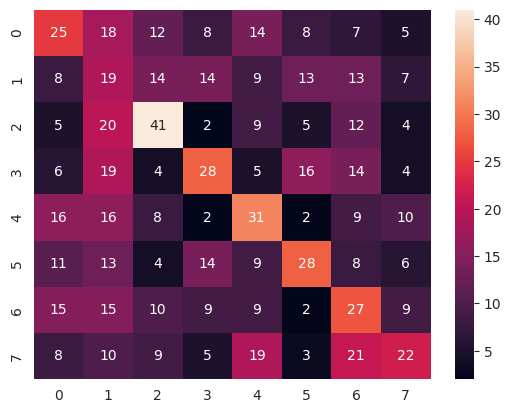

In [538]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_true.cpu(), test_pred.cpu())).rename(columns=idx_to_label, index=idx_to_label)
sns.heatmap(confusion_matrix(test_true.cpu(), test_pred.cpu()), annot=True)

In [539]:
def transform_idx_to_label(x):
    return idx_to_label[x]

In [540]:
print(classification_report(y_true=list(map(transform_idx_to_label, test_true.cpu().tolist())), y_pred=list(map(transform_idx_to_label, test_pred.cpu().tolist()))))

              precision    recall  f1-score   support

           2       0.27      0.26      0.26        97
          10       0.15      0.20      0.17        97
          12       0.40      0.42      0.41        98
          15       0.34      0.29      0.31        96
          17       0.30      0.33      0.31        94
          21       0.36      0.30      0.33        93
          38       0.24      0.28      0.26        96
        1235       0.33      0.23      0.27        97

    accuracy                           0.29       768
   macro avg       0.30      0.29      0.29       768
weighted avg       0.30      0.29      0.29       768



Странно что support одинаковый